In [1]:
from __future__ import absolute_import, division, print_function
import sys
import collections 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100, cifar10
from tqdm import tqdm
from IPython.display import clear_output

from scan_tf.models.resnet import resnet_18, resnet_34, resnet_50, resnet_101, resnet_152
import scan_tf.utils.utils as utils


# Grow memory to avoid mem overflow
memory_growth=True
if memory_growth:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

In [2]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 3
no_epochs = 100
optimizer = tf.keras.optimizers.Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:1000]
y_train = y_train[:1000]



X_train.shape
input_train = X_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Find number of classes dynamically
num_classes = y_train.shape[1]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Normalize data
X_train = (X_train / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_train.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 10)
X_test shape : (1000, 32, 32, 3)
y_test shape : (10000, 10)


In [3]:
model = resnet_18(num_classes=num_classes)
model.build(input_shape=(None, img_width, img_height, img_num_channels))
model.summary()

Model: "res_net_type_i"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148736    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  527488    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2103552   
_________________________________________________________________
sequential_5 (Sequential)    multiple               

In [4]:
# model.load_weights("resnet18_classification_with_rotnet.h5")

In [5]:
# model = tf.keras.models.load_model('resnet18_classification_with_rotnet.h5')
# # latest = tf.train.latest_checkpoint(checkpoint_dir)
# # # Load the previously saved weights
# # model.load_weights(latest)


# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

<h3>Training for minimizing the Rotation Loss</h3>

In [6]:
lr = 1e-4
e = 0
m = X_train.shape[0]
batch_size = 128

while True:
    e+=1
    batch_count = 0
#     for idx in tqdm(range(0, m, batch_size)): # batch
    for idx in range(0, m, batch_size): # batch
        images = tf.convert_to_tensor(X_train[idx:idx+batch_size, ...])
        labels = tf.convert_to_tensor(y_train[idx:idx+batch_size, ...])
        
        degrees_to_rotate = np.random.choice([90, 180, 270]) # randomly choosing the rotation angle
        
        images_rotated = tf.convert_to_tensor(scipy.ndimage.rotate(images, degrees_to_rotate, axes=(2, 1))) 

        with tf.GradientTape() as tape:
            embs_a, embs_b = model(images), model(images_rotated)
#             loss = tf.norm(embs_a-embs_b, ord='euclidean', axis=None, keepdims=None, name=None)
            loss = tf.reduce_sum(tf.norm(embs_a-embs_b, ord='euclidean', axis=(1), keepdims=None, name=None))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer = tf.keras.optimizers.Adam(lr=lr)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        #if batch_count%1==0:
            # mean_acc = np.mean(find_neighbor_accuracy(embs_a))
            # print(f"\tbatch {batch_count}, loss: {tf.reduce_sum(loss).numpy()}, mean_acc: {mean_acc}")
        batch_count+=1
    if e%1 == 0:
        #clear_output()
        print(f"epoch {e}, loss: {loss}")
    if e==20:
        break

epoch 1, loss: 2.2914021015167236
epoch 2, loss: 1.5615770816802979
epoch 3, loss: 1.118058443069458
epoch 4, loss: 0.8498767018318176
epoch 5, loss: 0.6809419393539429
epoch 6, loss: 0.5440929532051086
epoch 7, loss: 0.4688572287559509
epoch 8, loss: 0.3948378562927246
epoch 9, loss: 0.2797398865222931
epoch 10, loss: 0.245378315448761
epoch 11, loss: 0.18779954314231873
epoch 12, loss: 0.146094411611557
epoch 13, loss: 0.10334193706512451
epoch 14, loss: 0.0822477713227272
epoch 15, loss: 0.06201367825269699
epoch 16, loss: 0.050895702093839645
epoch 17, loss: 0.05038384348154068
epoch 18, loss: 0.038133297115564346
epoch 19, loss: 0.029285579919815063
epoch 20, loss: 0.02696317248046398


In [7]:
model.save_weights("resnet18_classification_with_rotnet.h5")

In [8]:
embeddings = model.predict(images)
print(f"Embeddings shape {embeddings.shape}")

Embeddings shape (104, 10)


<h3>Finding Nearest Neighbors</h3>

In [9]:
nn = utils.CLusteringNN(model, n_neighbors=5)
nn.fit(images)
print(nn.get_neighbors_indexes(images[0]))

[[  0  70  64 100  41]]


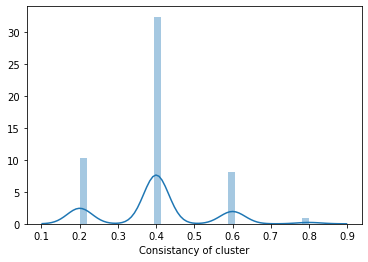

In [10]:
def find_neighbor_consistancy(images, labels, n_neighbors=5, plot=False):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    for cluster_indexes in nn_indexes:
        cluster_classes = true_classes[cluster_indexes]
        # Not sure which formula is better
        consistancy = (cluster_classes[1:]==cluster_classes[0]).sum()/(len(cluster_indexes)-1)
        # Not sure which formula is better
        cluster_label_counter = collections.Counter(cluster_classes)
        consistancy = cluster_label_counter.most_common()[0][1]/len(cluster_indexes)
        consistancies.append(consistancy)

    if plot:
        sns.distplot(consistancies)
    plt.xlabel("Consistancy of cluster")
    return consistancies
consistancies = find_neighbor_consistancy(X_train, y_train, n_neighbors=5, plot=True)

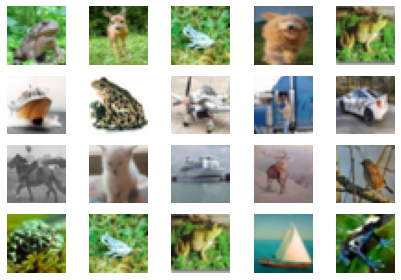

In [11]:
# Show center of cluster (first column) and cluster
def show_neighbors(images, labels, n_neighbors=5):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    n = 4
    f, axes = plt.subplots(n, n_neighbors)
    for i, cluster_indexes in enumerate(nn_indexes[:n]):
        for j, im_i in enumerate(cluster_indexes):
            axes[i,j].axis('off')
            axes[i,j].imshow(images[im_i])
    plt.tight_layout()
    plt.show()

show_neighbors(images, labels, n_neighbors=5)


## Semantic Clustering

In [15]:
def semantic_clustering_training(model, X_train, y_train):
    model.load_weights("resnet18_classification_with_rotnet.h5")
    n_neighbors = 5
    lr = 1e-4
    e = 0
    m = X_train.shape[0]
    batch_size = 128
    
    # Get clusters
    nn = utils.CLusteringNN(model, n_neighbors=n_neighbors)
    nn.fit(X_train)
    nn_indexes = nn.get_neighbors_indexes(X_train)

    while True:
        e+=1
        batch_count = 0
    #     for idx in tqdm(range(0, m, batch_size)): # batch
        for idx in range(0, m, batch_size): # batch
            
            images_indexes = []
            cluster_images_indexes = []
            batch_ids = np.random.choice(range(0, m), batch_size)
            for i in batch_ids:
                images_indexes += [nn_indexes[i][0]]*(n_neighbors-1)
                cluster_images_indexes += list(nn_indexes[i][1:])
            images = tf.convert_to_tensor(X_train[images_indexes, ...])
            cluster_images = tf.convert_to_tensor(X_train[cluster_images_indexes, ...])

            with tf.GradientTape() as tape:
                images_pred, cluster_images_pred = model(images), model(cluster_images)
                norm = tf.norm(images_pred-cluster_images_pred, ord='euclidean', axis=(1), keepdims=None, name=None)
                consistant_loss = tf.reduce_sum(tf.math.log(norm))
                
                _ = tf.reduce_sum(images_pred, 0) / len(images)
                entropy_loss = tf.reduce_sum(_ * tf.math.log(_))
                
                # print(entropy_loss)
                loss = consistant_loss + entropy_loss

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer = tf.keras.optimizers.Adam(lr=lr)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            #if batch_count%1==0:
                # mean_acc = np.mean(find_neighbor_accuracy(embs_a))
                # print(f"\tbatch {batch_count}, loss: {tf.reduce_sum(loss).numpy()}, mean_acc: {mean_acc}")
            batch_count+=1
        if e%1 == 0:
            #clear_output()
            print(f"epoch {e}, loss: {loss}")
        if e==1:
            break
semantic_clustering_training(model, X_train, y_train)

tf.Tensor(
[-2.5685015e-03  1.5176937e-03 -1.3312999e-03 -8.8842498e-05
  2.5944207e-03  5.9118439e-03 -1.3694600e-03  3.5505686e-03
 -5.0579789e-03  7.4657858e-03], shape=(10,), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)


0